<img align="center" src="../extra/logos/logos.png" width='800px'>

# Análisis básicos en el DataCube Chile &#127758;

En ese apartado, se verán las operaciones básicas que se pueden realizar con el DataCube:
1. Definir una área de estudio
1. Buscar productos y mediciones
1. Solicitar la información
1. Visualizar la información

Se puede tener una idea de los productos y la cobertura de las imágenes disponibles en el cubo en el [Explorador de imágenes](https://explorer.stage.earth.dataobservatory.net/).


>**Nota**: Este notebook contiene elementos extraídos desde [DataCube Australia](https://github.com/GeoscienceAustralia/dea-notebooks).

>**Nota**: Si tiene problemas para desplegar este notebook, abra una terminal de Linux (File -> New -> Terminal), navegue hasta la carpeta donde está este notebook y escriba `jupyter trust 02_Análisis_básico.ipynb`. Luego, vuelva a abrir el notebook.

## 1. Primeros pasos

Como en el notebook anterior, lo primero que se debe realizar: 

1. Cargar librerías
1. Definir área de estudio
1. Cargar información

In [1]:
%matplotlib inline

import datacube
import pandas as pd
import sys
from odc.ui import DcViewer

from datacube.utils.rio import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)

sys.path.append("../../dea-notebooks/Scripts")
from dea_plotting import display_map
from dea_plotting import rgb

Al momento de cargar información, esta vez se agrupará cada imagen por día

In [2]:
longitud_rango = (-71.5, -70.5)
latitud_rango = (-29.5, -28.5)

In [3]:
dc = datacube.Datacube(app='02_análisis')
ds = dc.load(product='usgs_aws_ls8c2_sr',
             x=longitud_rango,
             y=latitud_rango,
             time=("2020-01-01", "2021-12-31"),
             output_crs='EPSG:32719',
             resolution=(-30, 30),
             dask_chunks={"time": 1},
             group_by="solar_day")
ds

<xarray.Dataset>
Dimensions:                         (time: 58, x: 3311, y: 3750)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-01T14:38:52...
  * y                               (y) float64 6.846e+06 ... 6.734e+06
  * x                               (x) float64 2.553e+05 ... 3.546e+05
    spatial_ref                     int32 32719
Data variables:
    coastal_aerosol                 (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    blue                            (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    green                           (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    red                             (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    nir                             (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    swir1                           (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    swir2                           (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    surface_temperature             (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    thermal_radiance                (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    upwell_radiance                 (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    downwell_radiance               (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    atmospheric_transmittance       (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    emissivity                      (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    emissivity_stdev                (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    cloud_distance                  (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    quality_l2_surface_temperature  (time, y, x) int16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    pixel_qa                        (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    aerosol_qa                      (time, y, x) uint8 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    radsat_qa                       (time, y, x) uint16 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Si se compara este `Xarray` con el anterior, los parámetros de consulta son los mismos, a excepción del parámetro `solar_day`. Esta opción permite unir diferentes imágenes según el día solar, para generar escenas continuas. También incluye una opción (`fuse_func`) para especificar alguna función en particular para hacer la fusión ([más información sobre la función](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)).

Para revisar el efeco de `group_by`, el mismo gráfico triple:

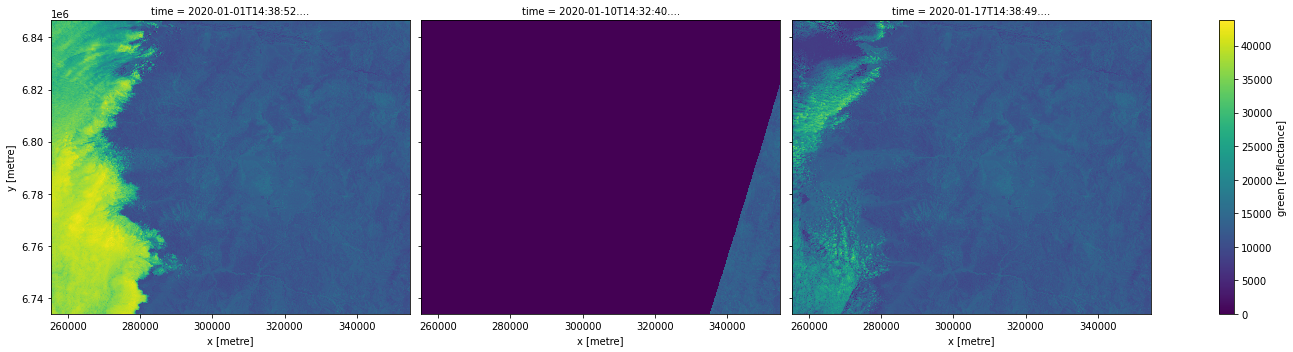

In [4]:
ds['green'].isel(time=range(3)).plot(col='time', figsize=(20, 5))

## 2. Depurar información

Tanto si el producto posee una banda de calidad o como si hay ciertos valores que se saben de antemano como inválidos o que se quieran aislar, es necesario incorporar esta información antes de realizar cualquier cálculo/análisis. Dependiendo de la naturaleza de los datos, este paso es opcional (pero altamente recomendable).

En este caso se está utilizando Landsat 8 que cuenta una banda de calidad:

In [5]:
from datacube.utils.masking import make_mask, mask_invalid_data, describe_variable_flags
import numpy as np

describe_variable_flags(ds)

,bits,values,description
snow,5,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
clear,6,"{'0': 'not_clear', '1': 'clear'}",NaN
cloud,3,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
water,7,"{'0': 'land_or_cloud', '1': 'water'}",NaN
cirrus,2,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
nodata,0,"{'0': False, '1': True}",NaN
pixel_qa,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{'1': 'Fill', '2': 'Dilated Cloud', '4': 'Cirr...",Level 2 pixel quality
cloud_shadow,4,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
dilated_cloud,1,"{'0': 'not_dilated', '1': 'dilated'}",NaN
cloud_confidence,"[8, 9]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN


En este primer paso, se aplicará una máscara para la nubosidad, utilizando la banda de calidad de Landsat. Para Landsat 8, un resumen de los valores apropiados puede ser encontrado [aquí](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LASRC_ProductGuide-v3.pdf). También se marcarán los píxeles inválidos por saturación, aquellos que excedan el rango de valores válidos y los que correspondan a NoData.

Siguiendo esa guía como paso, se fijan los valores válidos (libres de nubes) los que pertenezcan a la siguiente lista. Si la banda de calidad tiene alguno de estos valores, se considera que dicho pixel no tiene nubes.

>**Nota**: Al enmascarar, hay que considerar que lo que es `True` es lo válido (valores desados) y lo que se desea enmascarar, es `False`. En el fondo, los píxeles "buenos" son los que se marcan. 

Se utilizarán sólo las métricas que corresponden a reflectancia:

In [6]:
reflectance_names = ["coastal_aerosol", "blue", "green", "red", "nir", "swir1", "swir2"]

mask_cloud = make_mask(ds.pixel_qa, cloud='not_high_confidence', cloud_shadow='not_high_confidence', nodata=False) # genera máscara de nubes e inválidos (landsat aws)
mask_sat = ds.radsat_qa == 0 # pixeles no saturados
dsf = ds[reflectance_names].where(mask_cloud & mask_sat) 
dsf.update(dsf.where((dsf >= 1) & (dsf <= 65455), np.nan))

<xarray.Dataset>
Dimensions:          (time: 58, x: 3311, y: 3750)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-01T14:38:52.513207 ... 202...
  * y                (y) float64 6.846e+06 6.846e+06 ... 6.734e+06 6.734e+06
  * x                (x) float64 2.553e+05 2.553e+05 ... 3.546e+05 3.546e+05
    spatial_ref      int32 32719
Data variables:
    coastal_aerosol  (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    blue             (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    green            (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    red              (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    nir              (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    swir1            (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    swir2            (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Y luego, se pueden llamar las funciones gráficas. Valores inválidos (NA), aparecen ahora en blanco

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))


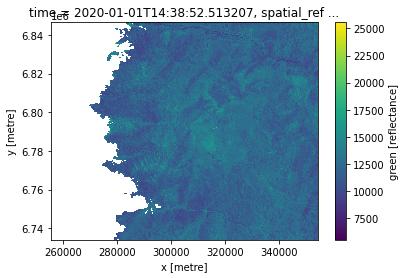

In [10]:
dsf['green'].sel(time='2020-01-01').plot() # Notar como ahora se utiliza la fecha (el valor) y no la posición.

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))


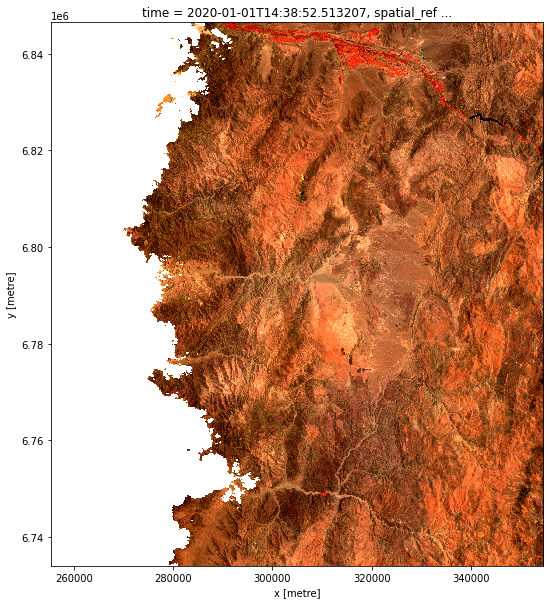

In [8]:
rgb(dsf, bands=["nir", "green", "blue"], index=0, size=10)

## 3. Cálculando índices espectrales

Los índices espectrales (vegetación, agua, nieve, etc) son ampliamente utilizados para identificar con mayor facilidad las estructuras que se desean estudiar. Uno de los índices para detectar vegetación más populares es el NDVI ([Normalised Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)), el cual ha sido ampliamente utilizado durante décadas. Este índice obedece a la siguiente fórmula:

$$\text{NDVI} = \frac{NIR-Red}{NIR + Red}$$

Siendo $NIR$ la reflectancia en el infrarrojo cercano y $Red$ la reflectancia en la banda roja. Este índice, puede tomar valores que van desde -1 a 1, siendo valores altos indicadores de mayor vegetación/vigor, valores cercanos a 0 suelo desnudo y valores negativos obedecen normalmente a cuerpos de agua, entre otros.

Antes de proceder, es necesario escalar los valores a reflectancia y luego calcular el índice. Para tener una idea sobre los valores de escalamiento para Landsat, se puede ver una guía [aquí] (https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2-level-2-science-products) y también [acá](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products?qt-news_science_products=0#qt-news_science_products)

In [11]:
dsf.update(dsf * 0.0000275 + -0.2)

<xarray.Dataset>
Dimensions:          (time: 58, x: 3311, y: 3750)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-01T14:38:52.513207 ... 202...
  * y                (y) float64 6.846e+06 6.846e+06 ... 6.734e+06 6.734e+06
  * x                (x) float64 2.553e+05 2.553e+05 ... 3.546e+05 3.546e+05
    spatial_ref      int32 32719
Data variables:
    coastal_aerosol  (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    blue             (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    green            (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    red              (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    nir              (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    swir1            (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
    swir2            (time, y, x) float64 dask.array<chunksize=(1, 3750, 3311), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Es importante notar como se pasó de `uint16` a `float64`. Ahora que ya están los valores escalados, se puede calcular el NDVI:

In [13]:
ndvi = (dsf.nir - dsf.red) / (dsf.nir + dsf.red)
ndvi

<xarray.DataArray (time: 58, y: 3750, x: 3311)>
dask.array<truediv, shape=(58, 3750, 3311), dtype=float64, chunksize=(1, 3750, 3311), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:38:52.513207 ... 2021-04...
  * y            (y) float64 6.846e+06 6.846e+06 ... 6.734e+06 6.734e+06
  * x            (x) float64 2.553e+05 2.553e+05 ... 3.546e+05 3.546e+05
    spatial_ref  int32 32719

>**Nota**: tal y como se mencionó anteriormente, en algunas ocasiones es muy útil utilizar `persist()` para obligar al conjunto de datos a hacer los cálculos que estén pendientes. Esto es útil particularmente antes de realizar una tarea que requiera dos o más veces el arreglo calculado. Por ejemplo, cada vez que se realiza un plot de la imagen, se calculan y extraen los datos. Como no se necesitan mayores cálculos una vez que se obtienen los índices (es el producto final de esta pasada), se puede usar en este paso.

In [ ]:
ndvi.persist()

## 4. Exportar información


# Mini - Tarea

Repetir el mismo 